# Overview
Now that we've looked at "average" activity for particular events, it's time to start extracting more complicated information from our brain signals. Today's lecture is going to introduce several new topics, some of which are pretty unintuitive and/or complex. However, they're crucial to understanding the electrophysiological signals we record from the brain. Today we'll discuss a new way to think about neural signals: like a collection of oscillations. We'll cover how to filter out certain kinds of information in our neural signals. Finally, we'll combine all of these methods in order to extract a particularly useful representation of data called a **time-frequency representation**.

## Goals for today
* Understand what it means to "filter" a signal?
* How to band-pass filter a signal
* How to extract a frequency band's amplitude with a Morlet wavelet.
* How to extract a time-frequency representation (TFR) with multiple Morlet wavelets.
* How to calculate a stimulus-evoked time-frequency representation.

---
# Recap from last week
Last week's lab took the idea of event-related activity a little bit further by asking you to analyze the brain activity in response to events in the world. It also calculated a few more 

# What does it mean to filter a signal?
In the data we've been playing with, you may have noticed that there seem to be patterns that repeat themselves in time. For example, let's look at one of our signals:

In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import neurods as nds
import datascience as ds
%matplotlib notebook

Opening raw data file /home/shared/cogneuro-connector/data/eeg/mne_sample/mne_sample-raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...


<IPython.core.display.Javascript object>


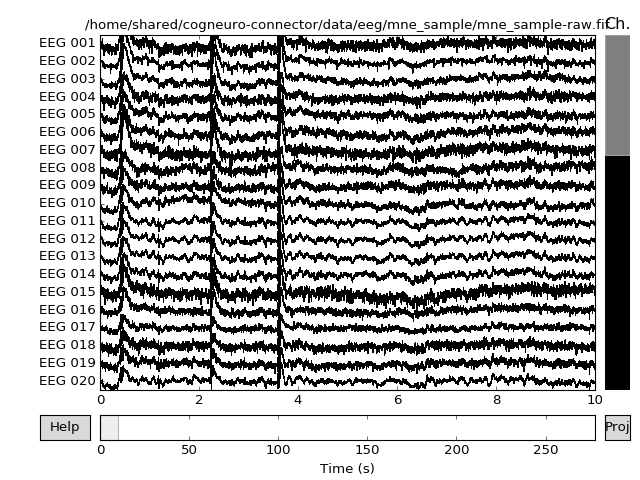

In [3]:
path_raw = nds.io.data_list['eeg'] + 'mne_sample/'
raw = mne.io.Raw(path_raw + 'mne_sample-raw.fif', preload=True, add_eeg_ref=False)
_ = raw.plot(scalings={'eeg': .00003})

As you see, there may be some kind of repeating structure present in these brain signals. How could we determine if this is true or not? To do so we need to discuss filtering and oscillations.

## Oscillations
Any pattern that repeats the same pattern over time we call *periodic*. This just means that this pattern oscillates over and over again.

Once we've got an oscillation, the next question is "how fast is it oscillating?". At this point, we are getting close to diving into a field called "signal processing". This is really complicated, and beyond the scope of this class. However, we can cover some basic concepts here.

We can define how often an oscillation occurs with its "frequency". This is measured in "Hertz" (Hz), and tells us how many times the pattern oscillates in a second. We've already covered the *sampling frequency* of a signal that we record. This is simply the number of samples we collect per second. When we talk about oscillations, the frequency means the number of *cycles* per second. For example, an oscillation with a 2Hz frequency oscillates 2 times every second. It has a "period" of 500 ms, the amount of time for one oscillation to occur.

For example, here's the temperature in Oakland over the next several days:

<img src="./images/weather_forecast.jpg", style="width: 600px;" />

As you can see, it rises and falls with each day. This is a periodic signal, with a period length of ~1 day. That means it has a frequency of:

$\frac{1\:cycle}{1\:day} * \frac{1\:day}{24\:hours} * \frac{1\:hour}{60 \:minutes} * \frac{1\:minute}{60\:seconds} = \frac{1\:cycle}{86400\:seconds} = 1.15e^{-5}Hz $

That's a *really* slow signal in terms of brains, which oscillate with a much shorter period (or a much higher frequency, however you want to look at it).

> * What are some other periodic signals we experience day to day?
> * What are some assumptions we seem to make when we say that a signal has a specific frequency?

In [4]:
### TEACHER INFO
# The first question has lots of answers, try to get some w/ longer and some
# w/ shorter periods.
# Some ideas for the second:
# * We assume that a signal is oscillatory in the first place
# * We assume that the oscillation always remains the same
# * We assume that the signal will go on forever

Let's take a look at how we can investigate oscillations in our neural signals.

## Filtering data (band-pass filters)
If we want to know what kinds of oscillations are present in our data, we can filter it so that only a certain kind of oscillation remains. For example, say we want to know what our data looks like if we only keep the components that are oscillating at 10Hz. How could we accomplish this?

Filtering a signal basically entails doing two things:

1. Defining the shape of your filter (e.g., a sine wave that oscillates at 10 Hz)
2. Determining how much overlap your signal has with that filter.
3. (optionally) doing this for many time points of the original signal, to see if the amount of overlap changes with time.

To filter our neural data at 10Hz, we need to define what our filter looks like...

<IPython.core.display.Javascript object>


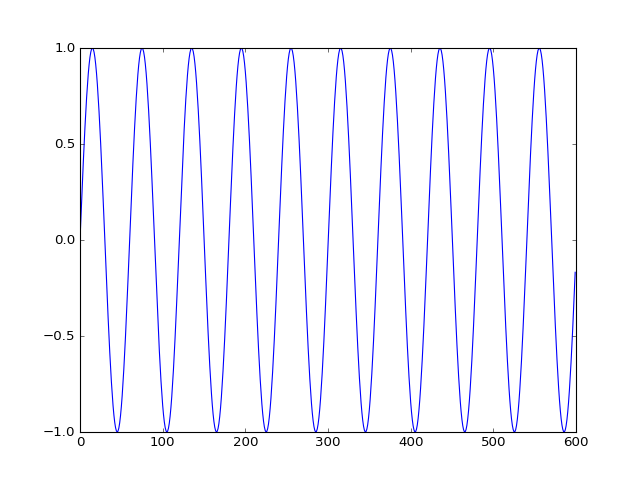

In [5]:
# We'll create a sine wave oscillating with a frequency of 10 Hz. It will oscillate between -1 and 1
freq = 10
amp = 1

# Here's the equation for a sine wave
sine = amp * np.sin(2 * np.pi * freq * raw.times)

# We'll plot 1 second of activity to confirm our frequency
f, ax = plt.subplots()
ax.plot(sine[:raw.info['sfreq'] * 1])

Say we wanted to know how much overlap there was between this sine wave and the signal. We could look at this by just multiplying the two, and then taking the average output. 

* If our signal is roughly the same shape as the sine wave, then the result will be nonzero.
* If our signal isn't correlated with the sin wave, then our result will tend to be zero.

In [6]:
# We'll just multiply the two together:
ix_pick = mne.pick_channels(raw.ch_names, ['EEG 054'])[0]
data_filtered = raw._data[ix_pick].copy()
data_filtered -= data_filtered.mean()
np.sum(sine * data_filtered)

-0.01077802028356124

However, in this case we've collapsed our original signal into a single number. But this removes a lot of information about how our signal changes in time.

To get around this, we'll shorten our sine wave signal, and then do this multiplication process for a *sliding window* moving across our neural signal.

We'll cut our sine wave so that it has length 400ms.

> * How many cycles does this amount to?

<IPython.core.display.Javascript object>


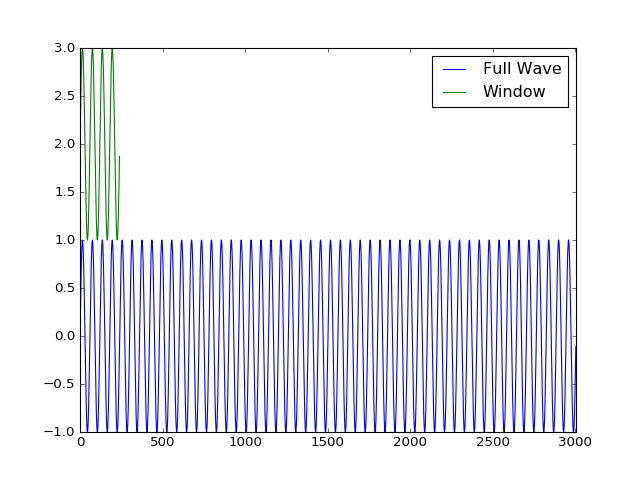

(0, 3003.074951171875)

In [7]:
sine_window = sine[:int(.4 * raw.info['sfreq'])]

# Make a quick plot for comparison.
fig, ax = plt.subplots()
ax.plot(sine[:5*raw.info['sfreq']])
ax.plot(sine_window + 2)
ax.legend(['Full Wave', 'Window'])
ax.set_xlim([0, 5*raw.info['sfreq']])

Next, we'll create a function that uses a sine wave to filter a dataset. We'll define this below...

In [8]:
def filter_with_sinewave(data, sinewave):
    len_window = sinewave.shape[-1]

    # We'll add zeros to the end of the signal so that we can move all the way through
    data_window_filtered_base = np.hstack([data_filtered, np.zeros(len(sinewave))])
    
    # Now, iterate through our original signal, multiplying by the sine window
    data_window_filtered = np.zeros_like(data_filtered)
    for i in range(data_filtered.shape[-1]):
        # Pull the data values for this window and subtract the mean
        i_data_window = data_window_filtered_base[i:i + len_window]
        i_data_window = i_data_window - np.mean(i_data_window)
        
        # Now multiple the window by our sine wave, and sum together.
        overlap = sinewave * i_data_window
        data_window_filtered[i] = np.sum(overlap)
    return data_window_filtered

> * Let's try to explain the above function in our own terms.
> * Why is it possible to do this relatively quickly?

In [9]:
### TEACHER INFO
# The point here is just to illustrate the usefulness of commenting code and
# functions.

Now, we'll use this function to filter our data with the sine wave that we created above.

First, we'll take at a snippet of sample data:

<IPython.core.display.Javascript object>


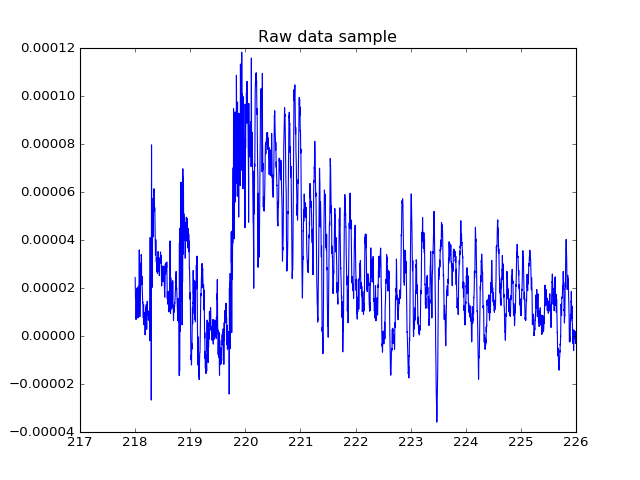

In [10]:
tmin, tmax = 218, 226
ixmin, ixmax = (raw.info['sfreq'] * np.array([tmin, tmax])).astype(int)
ixs_plot = np.arange(ixmin, ixmax)

fig, ax = plt.subplots()
ax.plot(raw.times[ixs_plot], data_filtered[ixs_plot])
ax.set_title('Raw data sample')

In [11]:
# Now we'll use our sinewave window and multiply it many times by the signal.
len_window = sine_window.shape[-1]
filtered_high_freq = filter_with_sinewave(data_filtered, sine_window)

> * What should the output look like? Will it look like our original signal?

In [12]:
### TEACHER INFO
# The point here is that people should get an intuition for the fact
# that we're going to change our signal in kind of wacky ways by doing this.
# Maybe they'll conclude that the output will look like a sine wave, but
# probably they'll just say it will be oscillating in more vague terms

<IPython.core.display.Javascript object>


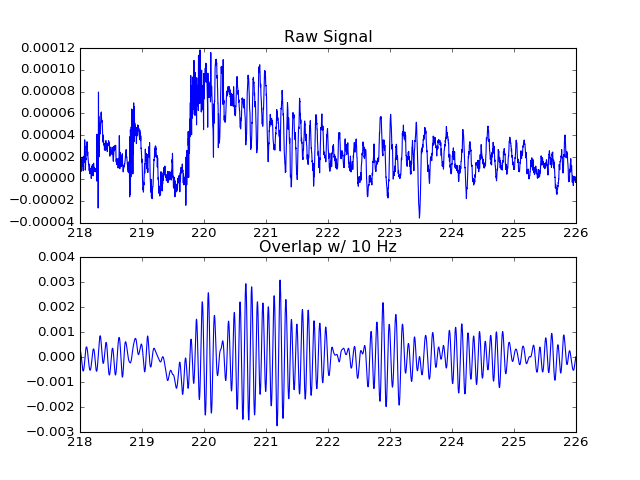

In [13]:
# We'll plot the output to see what it looks like:
f, axs = plt.subplots(2, 1)
axs[0].plot(raw.times[ixs_plot], data_filtered[ixs_plot])
axs[1].plot(raw.times[ixs_plot], filtered_high_freq[ixs_plot])

axs[0].set_title('Raw Signal')
axs[1].set_title('Overlap w/ {0:2d} Hz'.format(freq))
_ = plt.setp(axs, xlim=[raw.times[ixs_plot][0], None])


> * How have we shaped the original signal? What does it look like now?

What we've just done is very similar to a technique called *convolution*. This is a more rigorous way of filtering one signal using another. We won't go into the details of convolutions in this class, but know that you're doing something very similar to what's above every time you perform one.

Let's try a different frequency and see how the output changes:

<IPython.core.display.Javascript object>


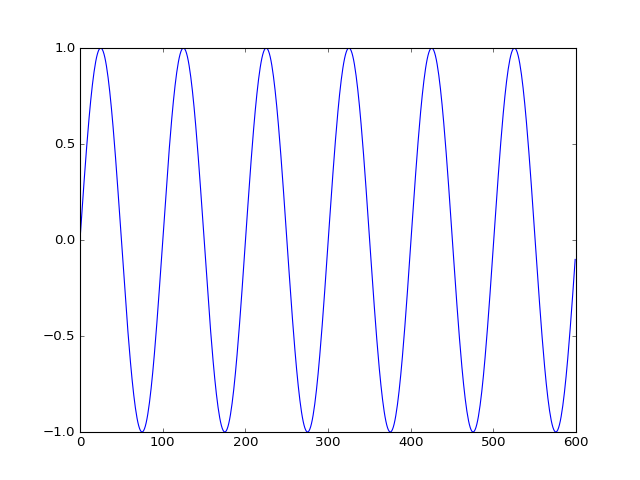

In [14]:
# We'll create a sine wave oscillating with a frequency of 6 Hz.
# It will oscillate between -1 and 1
freq = 6
sine = amp * np.sin(2 * np.pi * freq * raw.times)
sine_window = sine[:int(.4 * raw.info['sfreq'])]

# We'll plot 1 second of activity to confirm our frequency
f, ax = plt.subplots()
ax.plot(sine[:raw.info['sfreq'] * 1])

<IPython.core.display.Javascript object>


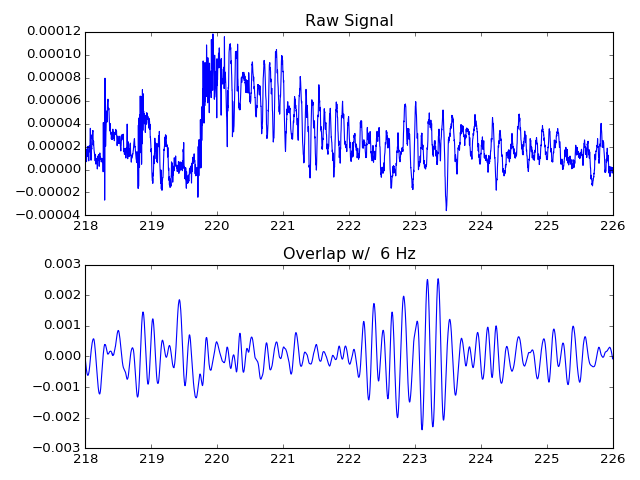

In [15]:
# Filter the signal using a lower-frequency wave
filtered_low_freq = filter_with_sinewave(data_filtered, sine_window)

# We'll plot the output to see what it looks like:
ixmin, ixmax = (raw.info['sfreq'] * np.array([tmin, tmax])).astype(int)
ixs_plot = np.arange(ixmin, ixmax)
f, axs = plt.subplots(2, 1)
axs[0].plot(raw.times[ixs_plot], data_filtered[ixs_plot])
axs[1].plot(raw.times[ixs_plot], filtered_low_freq[ixs_plot])

axs[0].set_title('Raw Signal')
axs[1].set_title('Overlap w/ {0:2d} Hz'.format(freq))
_ = plt.setp(axs, xlim=[raw.times[ixs_plot][0], None])
plt.tight_layout()

> * How do the two filtering procedures differ?
> * What information can we take from the output in either case?

In [16]:
### TEACHER INFO
# The two filtering procedures create output of differing frequencies, so
# one changes faster than the other.

# There are two things we can take from the signal. One is the general amplitude
# of the output, and the other is the phase of the output. Mention this but
# don't go into a ton of detail because we'll do that later.

### Filtering with MNE
Fortunately for us, there are many packages that use their own filtering code. For example, with MNE objects we can easily filter a signal. The easiest way to do this is with a `Raw` object's `filter` method:

We can do filtering with wavelets in a similar manner to how we used a sine wave earlier in this lecture. 

In [17]:
# The `filter` method takes a low frequency and a high frequency.
# It will filter out anything that's outside of these values
#raw.filter(
fmin, fmax = 9.5, 10.5
raw_filtered = raw.copy()
raw_filtered.filter(fmin, fmax)

Band-pass filtering from 9.5 - 10 Hz


<Raw  |  mne_sample-raw.fif, n_channels x n_times : 59 x 166800 (277.7 sec)>

<IPython.core.display.Javascript object>


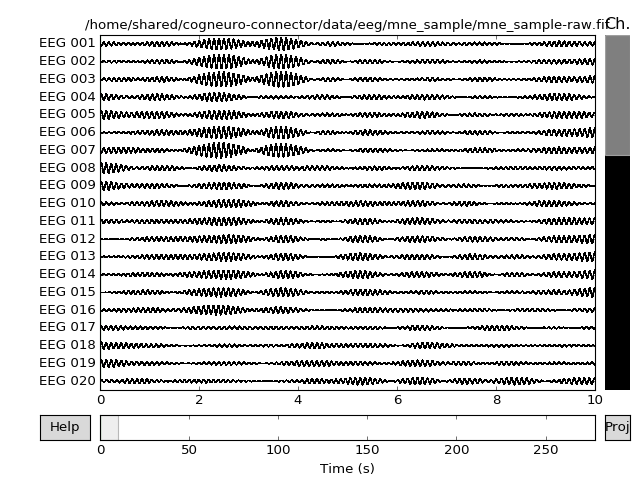

In [18]:
_ = raw_filtered.plot(scalings='auto')

We can see that our data now looks a lot cleaner. This is because we've removed all of the activity in our data that **isn't** oscillating at 10Hz.

When you filter a signal so that only a subset of frequencies remain, it is called a "band-pass" filter. This is because you've allowed a "band" of frequencies to pass through the filter, and all other frequencies are filtered out.

We can do the same filtering process for lower frequencies as well.

Band-pass filtering from 2 - 3 Hz


<IPython.core.display.Javascript object>


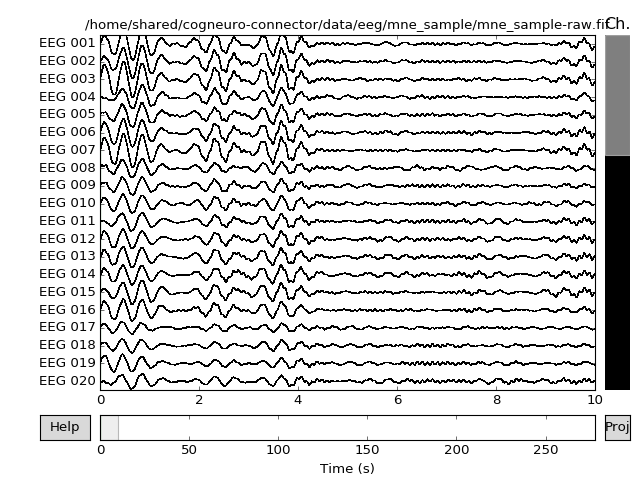

In [19]:
raw_filter_low = raw_filtered.filter(2, 3)
_ = raw_filter_low.plot(scalings='auto')

> * Why would we use the MNE filtering function instead of our own?

In [20]:
### TEACHER INFO
# Basically because filtering is a lot trickier than we've described here.
# Mention that strange things happen when we use a filter that has edges,
# and a lot of signal processing involves trying to get around these issues.

## Calculating the "amplitude" of a frequency
As we've seen above, after we filter a signal the resulting output can be "large" or "small". For example, in our sine-wave filtering, we saw that the resulting sinewave had large fluctuations in different timepoints depending on the filtering signal we used.

We can calculate the amplitude of a frequency in a number of ways. The simplest way to do this is with something called a "continuous wavelet transform". This is a fancier version of the window multiplication that we did manually above (it uses something called **wavelets** instead of sine waves, and is slightly more complicated).

### A quick primer on wavelets vs. sine waves
A wavelet is basically a sine wave with an amplitude that tapers off on both sides. For example:

<IPython.core.display.Javascript object>


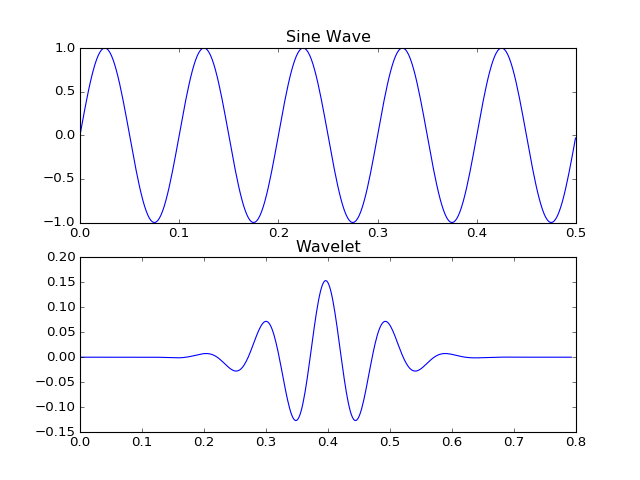

In [21]:
# Common to both signals
freq = 10
sfreq = raw.info['sfreq']
n_cycles = 5
time_stop = n_cycles * 1. / freq

# Simulate a sine wave
times_sine = np.arange(0, time_stop, 1. / sfreq)
sine = np.sin(2 * np.pi * freq * times_sine)

# Now create a wavelet at the same frequency / sfreq
Ws = mne.time_frequency.morlet(sfreq, [freq], n_cycles)[0]
times_wavelet = np.arange(Ws.shape[0]) / sfreq

# Plot each one
f, axs = plt.subplots(2, 1)
axs[0].plot(times_sine, sine)
axs[0].set_title('Sine Wave')
axs[1].plot(times_wavelet, np.real(Ws))
axs[1].set_title('Wavelet')

### The Continuous Wavelet Transform
In the example at the beginning of lecture, we use a sine wave as a window, multiplied the window by the signal, calculated the output, and then slid the window to the next time.

MNE has a helper function that quickly does the window multiplication that we did manually above (it uses wavelets instead of sine waves, and is slightly more complicated). Here's how to use it:

In [22]:
# Define frequencies and filter using wavelets for each frequency
freqs = [6]
out_wavelet = mne.time_frequency.cwt_morlet(data_filtered[np.newaxis, :],
                                            raw.info['sfreq'], freqs)

# We'll take the first item of the output, since we have 1 signal and 1 freq
out_wavelet = out_wavelet[0, 0]

# Taking the absolute value gives you the *amplitude* of the output
wavelet_amp = np.abs(out_wavelet)

# Taking the "real" value gives you the filtered signal:
wavelet_band = np.real(out_wavelet)

<IPython.core.display.Javascript object>


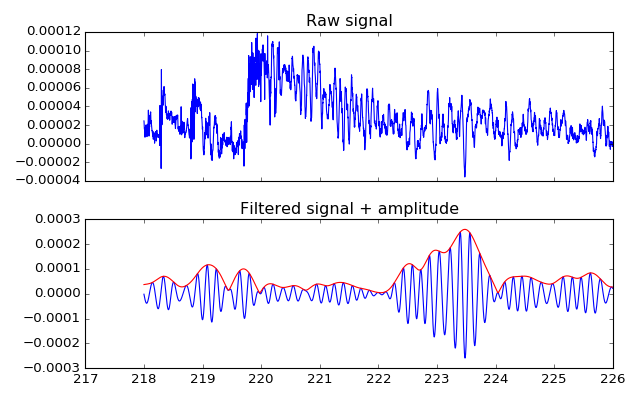

In [23]:
# Plot the results
f, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
time = raw.times[ixs_plot]
axs[0].plot(time, data_filtered[ixs_plot])
axs[0].set_title('Raw signal')

axs[1].plot(time, wavelet_band[ixs_plot])
axs[1].set_title('Filtered signal + amplitude')
axs[1].plot(time, wavelet_amp[ixs_plot], color='r')
plt.tight_layout()

By calculating the amplitude, we determine "how much" of this frequency is present in the signal at each moment in time.

> What's all this about taking the "real" part of a number? This begins to dive into the complicated world of signal processing. We won't cover this topic here, but the basic idea is that we can break down a signal into two parts. We call one of those parts the "real" part, and the other one the "imaginary" part. If we know both of these numbers for a signal, then we can calculate both its amplitude *and* its phase (which is another way of describing where in a cycle that signal happens to be).

> The important thing to remember is that the output of a wavelet transform gives us a set of **complex** numbers. We can get the raw filtered signal by taking the **real** component of those numbers, and we can get the amplitude of the frequency band by taking the **absolute value** of those numbers. 

## Frequencies in the brain
Why do we care about filtering the brain signal in these ways? There is a lot of research that suggests that different frequency patterns in neural signals might reflect different kinds of neural processes.

For example, you may have heard about "sleep waves" in the brain. These reflect the change in brain activity as you move through your sleep cycles. They are detected as a change in frequency content that's in your brain activity.

In neuroscience, we often split the full range of possible frequencies into pre-defined "frequency bands". These are some common bands:

* delta = 0-4 Hz
* theta = 4-7 Hz
* alpha = 8-15 Hz
* beta = 16-31 Hz
* gamma = 32-70 Hz
* high-gamma = >70 Hz

Here's an example of what some of these "brain waves" look like in the context of sleep:

<img src='./images/brain_waves.jpg' style="width: 400px;" />

As you move between sleep stages, there will be different amounts of each of the above frequency bands present in the signal. There is a rich literature in how to interpret and understand these "rhythms of the brain".

> * Why do you think that oscillations exist in the brain? Do they have a function?

In [24]:
### TEACHER INFO
# There isn't really an answer to this question, but the basic thought is to
# get at the question of whether oscillations have a role themselves, or if
# they are just a byproduct of neural activity. Get people thinking about
# whether oscillations seem to be a real thing.

## Time-Frequency Representations
The final component we'll cover today is an extension of the filtering that we just performed.

Recall that we can filter a signal, so that only a single frequency remained. The output of this filtering was a signal that varied in time, oscillating at the given frequency. The output looked like this:

<img src="./images/band_pass.jpg" style="width: 400px;" />

However, what if we want to split up our signal into *several* component frequencies? Moreover, we want to know the *amplitude* of the output at each frequency (as opposed to the raw filtered signal).

To do this, we need to create a bunch of band-pass filters. We'll filter the signal at multiple frequencies and calculate the amplitude of the output. This will tell us how the frequency content of a signal *changes* in time.

To accomplish this, we do the following:

* Define a range of frequencies that we care about (usually from lower to higher frequencies). Then:
* For each frequency band:
  * Band-pass filter the signal for that frequency
  * Calculate the **amplitude** of the output. This tells us "how much" of that frequency is present at each moment in time.
* Now we have 1 output signal per frequency, representing the time-varying **amplitude** of that frequency band.
* Stack all these signals, so that we now have data that has a shape (n_frequencies, n_times). This is called a **time-frequency representation**.

The Time-Frequency representation is often called a **spectrogram**. There are also many ways to create a spectrogram. We'll use the same wavelet transform we used above, but this time with many frequencies.

In [25]:
# First, we'll convert our data into trials
events = pd.read_csv(path_raw + 'mne_sample-events.csv')
events = events[['index', 'previous_value', 'event_type']].values
epochs = mne.Epochs(raw, events, tmin=-.5, tmax=1, preload=True)

# We'll select a subset of trials to speed things up
epochs_tfr = epochs.copy()['1']

# And resample so that computation is faster
epochs_tfr.resample(200)

320 matching events found
Applying baseline correction (mode: mean)
Adding average EEG reference projection.
Created an SSP operator (subspace dimension = 1)
4 projection items activated
Loading data for 320 events and 902 original time points ...
0 bad epochs dropped
npad is currently taken to be 100, but will be changed to "auto" in 0.13. Please set the value explicitly.


<Epochs  |  n_events : 72 (all good), tmin : -0.499488032896 (s), tmax : 0.995511967104 (s), baseline : (None, 0)>

In [26]:
# First, define a range of frequencies to extract from the signal
freqs = np.arange(4, 25, 1)

# Perform this function using the frequencies we want
n_decimate = 2
tfr = nds.tfr.tfr_morlet(epochs_tfr._data, epochs_tfr.info['sfreq'],
                         freqs, kind='amplitude', decimate=n_decimate)
times_new = epochs_tfr.times[::n_decimate]

100%|██████████| 72/72 [00:19<00:00,  3.71it/s]


This returns an array that is shape (n_trials, n_channels, n_frequencies, n_times).

In [27]:
# Note that we can access the raw TFR data too
# The TFR is of shape (n_epochs, n_channels, n_frequencies, n_timepoints)
tfr.shape

(72, 59, 21, 150)

It is a time-frequency representation of the data. We can use this to investigate a single time-frequency response for a channel, by averaging across trials for that channel:

<IPython.core.display.Javascript object>


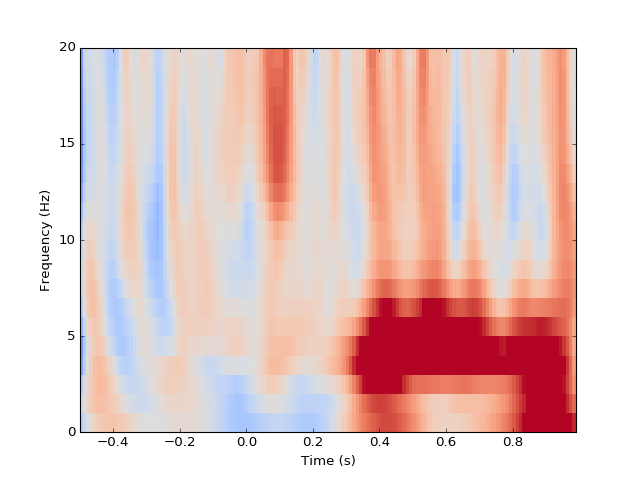

Applying baseline correction (mode: zscore)


In [28]:
ch_plt = 14
nds.viz.plot_tfr(times_new, freqs, tfr.mean(0)[ch_plt], use_log=True,
                 baseline=(None, 0), linear_y=True)

> * Do you see any structure in the time-frequency response here?
> * What do you think it means if there is an increase in activity in a specific band?
> * Can you think of any differences in interpreting the lower frequencies vs. the higher frequencies?

In [29]:
### TEACHER INFO
# There should be some clear evoked time frequency activity here.
# An increase in activity just means that there is "more" of that frequency
# present at that moment in time.
# One challenge we need to consider with lower frequencies is that we need
# more timepoints to get a good read on the amplitude of that frequency.

# Bonus: Testing for deviations from baseline with a confidence interval
While it's nice to show evoked activity by simply visualizing it, it's also important that we can make *statistical* statements about the data as well. Last week you learned about creating a confidence interval around some value (e.g., the difference between two conditions). This gives us an idea of the *uncertainty* for that value.

In this case, we'll see if there is an evoked pattern of activity at a particular frequency band, above the baseline times. We will first need to baseline our TFR data.

> * What does it mean to "baseline" a dataset?

We can baseline the data as follows:

In [30]:
# Define a baseline, and apply it to the data
baseline = (None, 0)
_ = mne.baseline.rescale(tfr, times_new, baseline, copy=False)

Applying baseline correction (mode: mean)


> * Why did I just throw away the variable, why didn't I assign it to something new?

In [31]:
### TEACHER INFO
# Because `copy=False` so it's modifying in place

Now that the data is baselined, each trial shows the increase in TFR activity *over* baseline. We'll perform the statistical test on the channel we showed above. The basic steps go like this:

To calculate a confidence interval on the evoked TFR power, do the following:
* Baseline the data with a mean baseline. `(None, 0)` means take all timepoints before `t==0` in the baseline. 
* Calculate a time range you wish to include
* Calculate a frequency range you wish to include
* Calculate the mean value of this time / frequency range for each trial.
* Perform a bootstrap test on the mean of these values to calculate the confidence interval.

In [32]:
# We'll eyeball the time range since we're not being rigorous here:
time_range = (.4, .8)
mask_time = nds.time_mask(times_new, time_range[0], time_range[1])

# Same for frequencies
freq_range = (3, 8)
mask_freqs = nds.time_mask(freqs, freq_range[0], freq_range[1])

In [33]:
data_stat = tfr[:, ch_plt, :, :]

# Pick freqs we want
data_stat = data_stat[:, mask_freqs, :]

# Pick times we want
data_stat = data_stat[:, :, mask_time]

# Now we have picked a subset of frequencies and times
print(data_stat.shape)

# Finally, we'll calculate the mean value for each trial
# We'll average out the 2nd dimension twice, leaving us w/ a vector length==n_trials
data_stat = data_stat.mean(axis=1).mean(axis=1)
print(data_stat.shape)

# Now we'll assign it to a Table for easy sampling
data_stat = ds.Table().with_columns([('mean', data_stat)])

(72, 5, 40)
(72,)


Now, we'll perform the bootstrap. We'll repeat it a thousand times, doing the following each time:

* Take a random sample of trials with replacement
* Calculate and store this sample's mean
* Finally, calculate a 95% confidence interval on this distribution of means

In [34]:
# Perform the bootstrap
n_boots = 1000
n_rows = data_stat.num_rows
means = np.zeros(n_boots)
for ii in range(n_boots):
    sample = data_stat.sample(n_rows, with_replacement=True)['mean']
    means[ii] = sample.mean()

# Calculate the confidence interval. We'll perform 2 intervals
clo99, chi99 = np.percentile(means, [.5, 99.5])
clo95, chi95 = np.percentile(means, [2.5, 97.5])

> * Why am I using .5 and 99.5 instead of 1 and 99?
> * What is the effect of choosing a larger confidence interval? Is it more or less conservative?

Finally, we'll plot the distribution of bootstrap means, and our confidence interval:

<IPython.core.display.Javascript object>


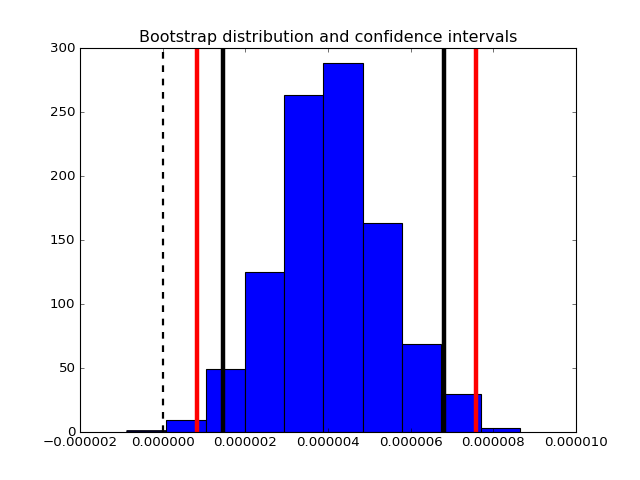

In [35]:
f, ax = plt.subplots()
ax.hist(means)
for clo, chi, color in [[clo99, chi99, 'r'], [clo95, chi95, 'k']]:
    ax.axvline(clo, color=color, lw=4)
    ax.axvline(chi, color=color, lw=4)
ax.axvline(0, color='k', ls='--', lw=2)
ax.set_title('Bootstrap distribution and confidence intervals')

> * Which color of vertical lines is the 99% confidence interval?
> * Can we conclude anything about the TFR's value relative to 0? Why?
> * Do you think this is "meaningful"? And why/why not?

In [ ]:
### TEACHER INFO
# Red is 99 because it's a more conservative test and thus the interval will be larger
# We can say that using a confidence interval test, the evoked mean is > 0
# Hard to say. The number is still very small, but they are very small numbers in the first place.
# This is a good place to have a general discussion about "statistical" significance vs. "practical" sig.

# Lab time!